## Wstęp

Dzisiaj zapoznasz się z jednym z najważniejszych zagadnień w kryptografii - czyli z funkcjami skrótu. Opowiemy sobie czym one są, do czego służą i gdzie są wykorzystywane na przykładzie standardu SHA-3.

## Funkcje skrótu

Zwane też: funkcje skracające, funkcje mieszające, funkcje haszujące, a z języka ang. *hashing functions*. W słowniku języka polskiego nie ma oficjalnej nazwy tych funkcji, dlatego podałem wszystkie z którymi możesz się spotkać w literaturze.

Z natury są to funkcje jednokierunkowe, które jako wejście przyjmują ciąg binarny o potencjalnie nieograniczonej długości, a jako wyjście zwracają ciąg binarny zawsze tej samej długości:
$$
h: \{0, 1\}^* \rightarrow  \{0, 1\}^n
$$
gdzie *h* oznacza funkcję skrótu, a *n* to długość zwracanego skrótu. Ta matematyczna definicja nie uwzględnia jednak pewnych dodatkowych właściowści, które funkcja skótu powinna posiadać. Są to:
- skrót powinien być łatwy do obliczenia (wydajność),
- dysponując funkcją skrótu *h* oraz skrótem oznaczonym jako *h(x)* powinno być niewykonalne (a przynajmniej bardzo, bardzo trudne) znalezienie wartości *x*. Ta własność jest określana jako bezpieczeństwo pierwszego preobrazu (z ang. *first preimage resistance*),
- mając **podane** *h* oraz *x*, powinno być bardzo trudne odnalezienie wartości *y* takiej, że *h(x) = h(y)*. Ta własność jest określana jako bezpieczeństwo drugiego preobrazu (z ang. *second preimage resistance*),
- powinno być także trudno znaleźć dwie **dowolne** wartości *x* oraz *y* takie, że *h(x) = h(y)*. Ta własność zwana jest odpornością na kolizje (z ang. *collision resistance*).

Bezpieczeństwo funkcji skrótu podajemy w tzw. bitach bezpieczeństwa. Jeżeli funkcja skrótu posiada *b* bitów bezpieczeństwa odporności na dany atak, to znaczy, że atakujący musałby wykonać $2^b$ operacji aby atak się udał. Teoretyczne maksymalne wartości liczby bitów bezpieczeństwa to $n$ w przypadku ataków na pierwszy i drugi preobraz, oraz $\frac{n}{2}$ w przypadku szukaniu kolizji (ta wartość wynika z [paradoksu urodzin](https://en.wikipedia.org/wiki/Birthday_problem)), gdzie tak jak poprzednio *n* oznacza długość zwracanego skrótu. Mówiąc o bezpieczeństwie trzeba jednak pamiętać o jednym. Każda funkcja skrótu jest do złamania. Wynika to z prostego faktu: posiadamy teoretycznie nieograniczoną liczbę wejść, a ograniczoną (choć za zwyczaj jest to wartość duża) liczbę wyjść.

No dobrze, tylko gdzie my możemy funkcje skrótu wykorzystać? Obecnie wyszczególniłbym następujące schematy wykorzystujące funkcje skrótu:
- przechowywanie haseł w bazie danych,
- weryfikacja integralności danych (w szczególności schematy podpisu cyfrowego),
- kryptografia post-quantum, w szczególności gałąź zwana *hash-based cryptography*, o której więcej możesz przeczytać [tutaj](https://en.wikipedia.org/wiki/Hash-based_cryptography).

W historii były cztery światowe standardy: SHA-0, SHA-1, SHA-2 i SHA-3, gdzie skrót *SHA* oznacza z ang. *Secure Hash Algorithm*. Standaryzacją zajmuje się organizacja NIST (*National Institute of Standards and Technology*) ulokowana w USA. Mało popularny SHA-0 oraz znacznie popularniejszy SHA-1 są **niezalecane do użycia**. Zostały złamane. SHA-2 i SHA-3 to już nie pojedyncze funkcje skrótu, ale raczej ich rodziny. Oznaczenie SHA-256 mówi nam o funkcji skrótu z rodziny SHA-2 zwracającej 256 bitowy skrót. Analogicznie SHA3-256. Najbardziej popularne długości skrótu (choć oczywiście nie jedyne) to 256 i 512 bitów. Standardy SHA które nie zostały złamane i zaleca się je do użycia określamy mianem SHS (z ang. *Secure Hash Standard*).

## SHA-3

Po serii udanych ataków na funkcję SHA-1, które miały miejsce w 2004 i 2005 roku, świat został z w zasadzie jednym standardem, SHA-2. NIST i specjaliści z całego świata byli zgodni, że to ryzykowane nie mieć żadnej bezpiecznej alternatywy - stąd w 2007 roku ogłoszono konkurs na SHA-3. Konkurs miał 3 rundy i trwał dość długo, bo wpłynęły aż 64 zgłoszenia. Ostatecznie w 2012 roku ogłoszono, że zwycięzcą został algorytm Keccaka i to on stał się nowym standardem, SHA-3. Dzisiaj go zaprogramujemy.

Czy SHA-3 jest trudny do zaprogramowania? Powiem tak. Moim zdaniem, korzystając tylko z dokumentacji twórców trochę tak, bo jest kilka małych pułapek. Dlatego opiszę Ci krok po kroku co powinno się zrobić i będzie nieco łatwiej.

Dla zainteresowanych przydatne linki: [strona twórców](https://keccak.team/keccak_specs_summary.html), [NIST FIPS PUB 202](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.202.pdf) i ostatnia, **ważna** która przyda nam się na końcu ćwiczeń: [debug data](https://csrc.nist.gov/Projects/cryptographic-standards-and-guidelines/example-values) - interesuje nas wiersz SHA3-512 z tabeli.



### Krok 1 - stałe

SHA-3 jest bardzo wszechstronny, pozwala dopasować wersję algorytmu do długości słowa bitowego obsługiwanego przez nasz procesor. Dla najbardziej popularnej długości obecnie, czyli 64 bity, stosuje się wersję algorytmu zwaną Keccak-1600. Można stosować inne, opisane w NIST FIPS PUB 202, ale my kierujemy się wydajnością. 1600 oznacza, że w każdej rundzie algorytmu będziemy operować na 1600 bitach danych, a więc 200 bajtach. Ta liczba oczywiście jest nieprzypadkowa. Zauważ, że 200 bajtów, to dokładnie 25 słów bitowych, każde po 64 bity. Te 25 słów bitowych formowane jest w dwuwymiarową tablicę 5x5. Ta tablica zwana jest przez twórców *State*.

No dobrze, ale jak się do tego ma wiadomość? Tutaj z pomocą przychodzą dwie stałe: $r$ oraz $c$ opisane [tu](https://keccak.team/keccak.html). Stała $r$ oznacza *bit rate*, $c$ *capacity*, a ich wartości zależą od tego, jaką wersję algorytmu SHA-3 zastosujemy (my skupimy się na SHA3-512). SHA-3 działa na zasadzie funkcji gąbki, to znaczy w pętli głównej wchłaniana jest odpowiednia liczba bitów wiadomości do tablicy state, wykonujemy odpowiednie obliczenia, wchłaniamy kolejną porcję, liczymy itd. W naszym przypadku $r = 576$ bitów, a więc 72 bajty. $c$ to po prostu uzupełnienie, zauważ, że wchłaniana liczba bitów jest mniejsza niż rozmiar State, stąd dla $c = 1024$, $r + c = 1600$.

$n$ oznacza liczbę rund. Po wchłonięciu porcji danych $n$ razy wykonujemy zestaw funkcji opisanych przez twórców (o których później), gdzie $n = 12 + 2l$. Z tabeli 1 w dokumentacji NIST można wyczytać, że dla wersji Keccak-1600, $l = 6$, a więc nasza liczba rund to $n = 24$.

$RC$ to tablica 24 stałych, po jednej dla każdej z 24 rund, natomiast $rotations$ to tablica wartości, która mówi nam o ile mamy rotować słowo bitowe. Jest ona potrzebna w jednej funkcji z zestawu przedstawionego przez twórców.

Zadeklarujmy nasze stałe. Dla wygody wartości $r$ oraz $c$ zadeklarujemy jako liczbę bajtów. 

In [1]:
n = 24
r = 576 // 8
c = 1024 // 8

s = 5
b = 64 // 8
l = 512 // 8

RC = [0x0000000000000001,
      0x0000000000008082,
      0x800000000000808A,
      0x8000000080008000,
      0x000000000000808B,
      0x0000000080000001,
      0x8000000080008081,
      0x8000000000008009,
      0x000000000000008A,
      0x0000000000000088,
      0x0000000080008009,
      0x000000008000000A,
      0x000000008000808B,
      0x800000000000008B,
      0x8000000000008089,
      0x8000000000008003,
      0x8000000000008002,
      0x8000000000000080,
      0x000000000000800A,
      0x800000008000000A,
      0x8000000080008081,
      0x8000000000008080,
      0x0000000080000001,
      0x8000000080008008]

rotations = [[0, 36, 3, 41, 18], [1, 44, 10, 45, 2], [62, 6, 43, 15, 61], [28, 55, 25, 21, 56], [27, 20, 39, 8, 14]]

### Krok 2 - Padding

Zauważ, że w każdej głównej iteracji algorytmu wchłaniamy 72 bajty wiadomości (wartość $r$). Jest bardzo mało prawdopodobne, że nasza wiadomość będzie akurat miała długość w bajtach równą 72 lub wielokrotności 72. Tutaj z pomocą przychodzi *padding*, czyli uzupełnianie wiadomości do wymaganej długości. Wskazówka: jako *wiadomość* rozum ciąg bajtów, czyli *bytearray* z którym będziemy robić sporo rzeczy.

SHA-3 stosuje metodę pad10*1, czyli w zamyśle dołącz do wiadomości bit 1, następnie odpowiednią liczbę bitów 0 i zamknij ciąg bitem 1. W SHA-3 ten algorytm jest wzbogacony o stałą 0x06:

1) Oblicz q = r - (len(msg) mod r). Zauważ, że $r$ i $len(m)$ zwracają długości w bajtach.

2) Jeżeli q = 1 wykonaj: dołącz do wiadomości bajt 0x86.

3) Jeżeli q = 2 wykonaj: dołącz do wiadomości bajt 0x06, a następnie dołącz do wiadomości bajt 0x80.

4) Jeżeli q > 2 wykonaj: dołącz do wiadomości bajt 0x06, następnie dołącz do wiadomości dokładnie $q - 2$ bajty 0x00 i na końcu dołącz do wiadomości bajt 0x80.

Sprawdź reprezentację bitową 0x80 oraz 0x81, jak wspominałem stała 0x06 to już dodatek autorów. Czy widzisz w powyższym algorytmie coś dziwnego? Jakiego porządku bitów używa SHA-3? W każdym przypadku, po operacji paddingu len(msg) powinno być wielokrotnością 72.

**Zadanie 1**

Napisz ciało metody pad10*1. Parametrem metody jest tablica bajtów wiadomości (bytearray).

In [2]:
def pad(msg):
    q = r - (len(msg) % r)
    
    if q == 1:
        msg.append(0x86)
    else:
        msg.append(0x06)
        msg += bytearray(q - 2)
        msg.append(0x80)
        
    return msg

### Krok 3 - funkcje pomocnicze

Będziemy potrzebowali operować na wartości State na dwa sposoby: raz jako na tablicy bajtów o długości 1600 (potrzebne przy wchłanianiu danych), a raz jako na dwuwymiarowej tablicy 64-bitowych słów o rozmiarach 5x5 (potrzebne w dalszej części). Musimy napisać łącznie trzy funkcje pomocnicze:

1) convertToInts(state) - ta funkcja powinna pobierać State w formie wektora bajtów i zwracać tablicę 5x5. Algorytm jest taki, że licząc od początku pobieramy po 8 bajtów (64 bity) i przypisujemy do nowego State'a (oznaczmy go jako State'), ale uwaga, dane układamy wierszami. A więc bajty 0-7 wektora State konwertujemy na liczbę i przypisujemy do State'[0][0], bajty 8-15 ze State przypisujemy jako liczbę do State'[1][0] itd. Dodatkowo, konwertując bajty na liczby używamy porządku **Little Endian**.

2) convertToBytes(state) - ta funkcja pobiera State jako dwuwymiarową tablicę i konwertuje z poworotem na wektor bajtów State' (nowy State). Dane również pobieramy wierszami i dekodujemy w porządku **Little Endian**. A więc liczba przechowywana w State[0][0] jest kodowana jako 8 pierwszych bajtów State', liczba w State[1][0] jako 8 kolejnych bajtów itd. Czyli robimy funkcję odwrotną do poprzedniej. Funkcja zwraca State' o rozmiarze 1600 bajtów.

3) rot(a, n) - ta funkcja dokonuje bitowej rotacji 64 bitowej liczby $a$ w lewo o $n$ bitów.

**Zadanie 2**

Uzupełnij ciała metod convertToBytes oraz convertToInts zgodnie z powyższym opisem.

In [3]:
def convertToInts(state):
    ints_arr = [[] for _ in range(s)]
    
    for row, pos in enumerate(range(0, c + r, b)):
        x = int.from_bytes(state[pos:pos + b], 'little')
        ints_arr[row % s].append(x)
        
    return ints_arr


def convertToBytes(state):
    bytes_vec = bytearray()
    
    for col in range(s):
        for row in range(s):
            x = state[row][col].to_bytes(b, 'little')
            bytes_vec += x
            
    return bytes_vec


def rot(a, nb):
    return ((a << nb) | (a >> (8 * b - nb))) & ((1 << 8 * b) - 1)

### Krok 4 - permutacje

SHA-3 wykorzystuje zestaw pięciu permutacji, które wykorzystywane są w każdej pojedynczej rundzie (*rundzie*, nie iteracji pętli głównej algorytmu). Nie są one skomplikowane, dlatego nie będziemy pisali oddzielnej funkcji do każdej z nich. Każda z nich korzysta ze State'a jako tablicy liczby 5x5.

1) Krok $Θ$ wykonaj:
- C[i] = state[i,0] xor state[i,1] xor state[i,2] xor state[i,3] xor state[i,4] dla i = 0,...,4. C to wektor pomocniczy.
- D[i] = C[i-1] xor rot(C[i+1], 1) dla i = 0,...,4, D to wektor pomocniczy.
- state[i][j] = state[i][j] xor D[i], dla i,j = 0,...,4.

2) Kroki $ρ$ oraz $π$ wykonaj: B[j][2 * i + 3 * j] = rot(state[i][j], rotations[i][j]), B to zmienna pomocnicza.

3) Krok $Χ$ wykonaj: state[i][j] = B[i][j] xor ((~B[i + 1][j]) & B[i + 2][j]).

4) Krok $ι$ wykonaj: state[0][0] = state[0][0] xor RC. RC to stała, którą będziemy przekazywać do funkcji realizującej te permutacje.

Ostatecznie mamy do napisania dwie funkcje w pythonie: *compute* i *oneRound*.

Funkcja *compute(state)* przyjmuje jako parametr State w formie wektora bajtów i wykonuje następujące czynności:

1) Przekonwertuj State do formy tablicy liczb.

2) Wykonuj *state = oneRound(state, RC[i])* dla i = 0,...,n-1

3) Przekonwertuj State do wektora bajtów.

4) Zwróc State.

Funkcja *oneRound(state, RC)* wykonuje obliczenia dla pojedynczej rundy:

1) Utwórz niezbędne zmienne pomocnicze.

2) Wykonaj krok $Θ$.

3) Wykonaj kroki $ρ$ oraz $π$.

4) Wykonaj krok $Χ$.

5) Wykonaj krok $ι$.

6) Zwróć State.

**Zadanie 3**

Uzupełnij ciała metod *compute* i *oneRound* zgodnie z algorytmem opisanym powyżej.

In [4]:
def compute(state):
    state = convertToInts(state)
    
    for i in range(n):
        state = oneRound(state, RC[i])
        
    return convertToBytes(state)


def oneRound(state, RC):
    B = [[0 for _ in range(s)] for _ in range(s)]
    C = [state[i][0] ^ state[i][1] ^ state[i][2] ^ state[i][3] ^ state[i][4] for i in range(s)]
    D = [C[(i - 1) % s] ^ rot(C[(i + 1) % s], 1) for i in range(s)]
    
    for i in range(s):
        for j in range(s):
            state[i][j] ^= D[i]
            B[j][(2 * i + 3 * j) % s] = rot(state[i][j], rotations[i][j])
            
    for i in range(s):
        for j in range(s):
            state[i][j] = B[i][j] ^ (~B[(i + 1) % s][j] & B[(i + 2) % s][j])
            
    state[0][0] ^= RC

    return state

### Krok 5 - główna pętla algorytmu

Wreszcie możemy napisać funkcję główną liczącą skrót *sha3-512*. Przyjmuje ona jako parametr bajty wiadomości $m$ i zwraca bajty skrótu:

1) Dokonaj paddingu wiadomości.

2) Wchłoń $r$ bajtów wiadomości do State'a. "Wchłanianie" oznacza tu operację XOR kolejnych bajtów wiadomości z $r$ początkowymi bajtami State'a.

3) Wywołaj metodę *compute(state)*.

4) Powtarzaj kroki 2 i 3 dopóki cała wiadomość nie zostanie wchłonięta.

5) Zwróć pierwsze 64 bajty State'a. To jest nasz 512-bitowy skrót.

**Zadanie 4**

Uzupełnij kod poniższej metody tak, aby zwracała skrót z wiadomości. Przetestuj tę metodę, czy działa prawidłowo. Tablicę bajtów przez nią zwróconą trzeba przekonwertować na ciąg znaków hexadecymalnych i wypisać na ekranie. Przetestuj funkcję dla poniższych ciągów znakowych:

1) ""

2) "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"

3) "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"

Porównaj, czy skróty zgadzają się ze zwróconymi z [tego](https://www.browserling.com/tools/sha3-hash) kalkulatora lub zaimportuj bibliotekę hashlib i porównaj swoje wyniki z jej wynikami.

In [5]:
def sha3_512(m):
    m = pad(m)
    state = bytearray(r + c)
    
    for pos in range(0, len(m), r):
        state[:r] = bytearray((a ^ b for a, b in zip(state[:r], m[pos:pos + r])))
        state = compute(state)
    
    return state[:l]

In [6]:
import hashlib


def hash_string(s):
    bytes_vec = sha3_512(bytearray(s, 'UTF-8'))
    return ''.join(format(x, '02x') for x in bytes_vec)


for test_str in ['', 'a' * 72, 'a' * 80]:
    print(hash_string(test_str))
    assert hash_string(test_str) == hashlib.sha3_512(test_str.encode()).hexdigest()

a69f73cca23a9ac5c8b567dc185a756e97c982164fe25859e0d1dcc1475c80a615b2123af1f5f94c11e3e9402c3ac558f500199d95b6d3e301758586281dcd26
a8ae722a78e10cbbc413886c02eb5b369a03f6560084aff566bd597bb7ad8c1ccd86e81296852359bf2faddb5153c0a7445722987875e74287adac21adebe952
208c7a62579fc826dd6be329089bba5e782f01a2ca3d9890a583042560164e97eda638108d69cc965aa8c6c073256717d9c4985921f43544a7a5675148b13c1f


**Zadanie 5**

Porównaj szybkość działania Twojej implementacji SHA3-512 z implementacjami SHA3-512 oraz SHA-512 dostępnymi w bibliotece hashlib. Postaraj się aby porównanie uwzględniało zarówno dane bardzo małe, jak i duże (na ile Ci pozwoli collab), a wyniki przedstaw na wykresie.

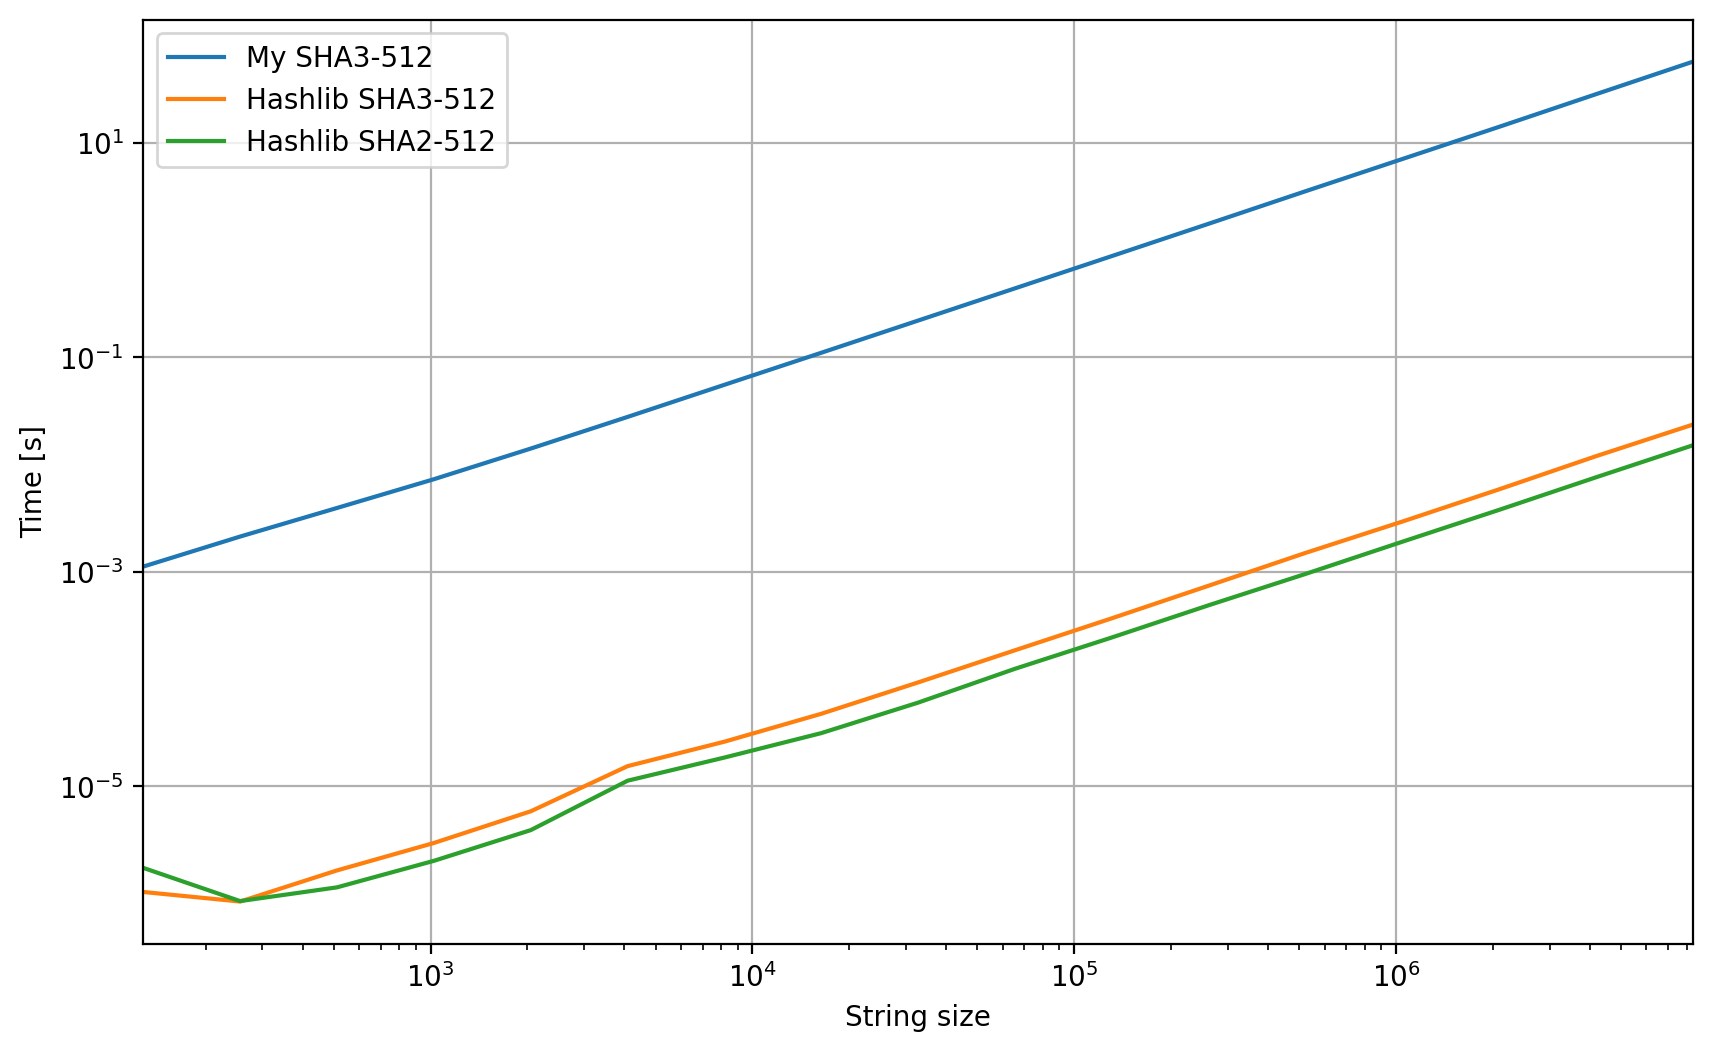

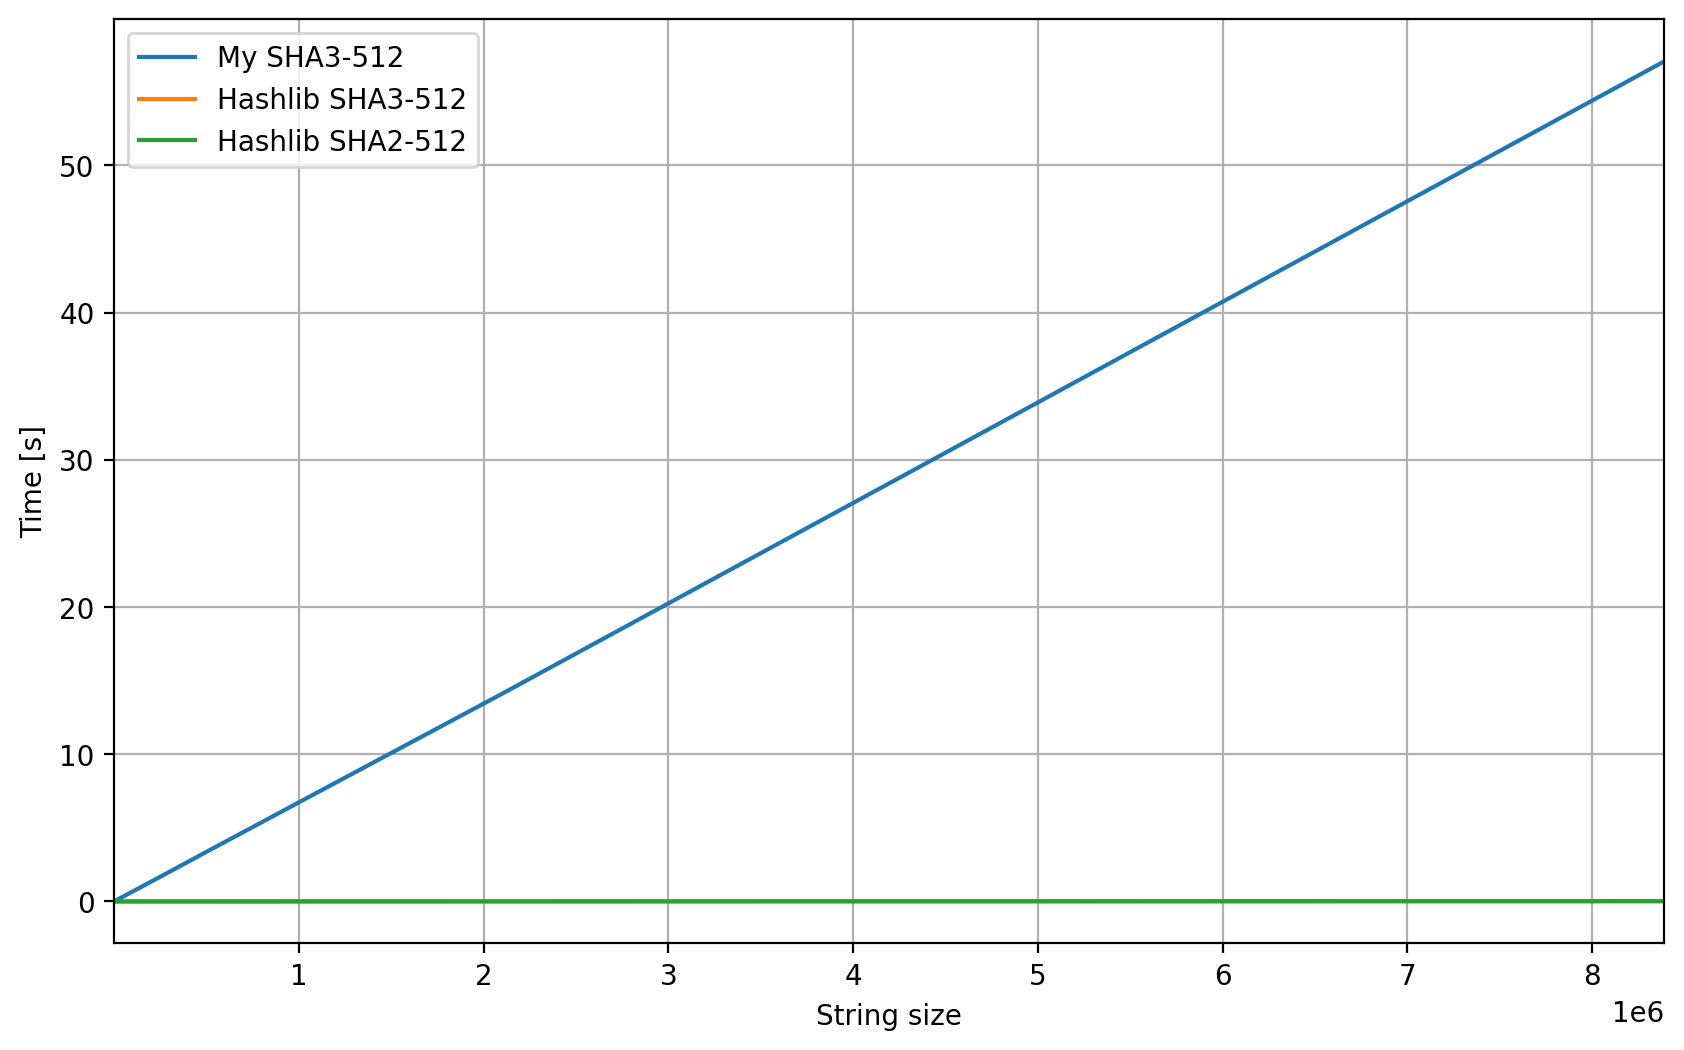

In [7]:
import matplotlib.pyplot as plt
import string
from random import choices
from time import perf_counter


def timer(func, args, n_rep=5):
    results = []

    for _ in range(n_rep):
        start = perf_counter()
        func(*args)
        end = perf_counter()

        results.append(end - start)

    return sum(results) / n_rep


str_size = [2 ** i for i in range(7, 24)]

results_my_sha3 = []
results_hashlib_sha3 = []
results_hashlib_sha2 = []


for k in str_size:
    test_str = ''.join(choices(string.ascii_letters + string.digits, k=k))

    results_my_sha3.append(timer(hash_string, (test_str,)))
    results_hashlib_sha3.append(timer(hashlib.sha3_512, (test_str.encode(),)))
    results_hashlib_sha2.append(timer(hashlib.sha512, (test_str.encode(),)))


def plot_results(log_scale=True):
    plt.figure(figsize=(10, 6), dpi=200)

    plt.plot(str_size, results_my_sha3, label='My SHA3-512')
    plt.plot(str_size, results_hashlib_sha3, label='Hashlib SHA3-512')
    plt.plot(str_size, results_hashlib_sha2, label='Hashlib SHA2-512')

    plt.xlabel('String size')
    plt.ylabel('Time [s]')

    plt.xlim((str_size[0], str_size[-1]))
    plt.xscale('log' if log_scale else 'linear')
    plt.yscale('log' if log_scale else 'linear')

    plt.grid()
    plt.legend()

    plt.show()


plot_results(log_scale=True)
plot_results(log_scale=False)

**Zadanie 6**

Przerób powyższy kod tak, aby stał się funkcją SHA3-256.

In [8]:
r = 1088 // 8
c = 512 // 8
l = 256 // 8